In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.debugger import set_trace

In [3]:
def check_type(y,t): # Ensure Input is Correct
    return y.dtype == np.floating and t.dtype == np.floating

class _Integrator():
    
    def integrate(self,func,y0,t):
        time_delta_grid = t[1:] - t[:-1]
        
        y = np.zeros((y0.shape[0],t.shape[0]))
        y[:,0] = y0
        
        # Euler Step or Runge-Kutta Second Order Integration Step
        for i in range(time_delta_grid.shape[0]):
            y[:,i+1] = time_delta_grid[i]*func(y[:,i],t[i])+y[:,i] # Euler Integration Step
            
            #Un-Comment the next three lines to use the Runge-Kutta Second Order Integration
            #k1=(1/2)*time_delta_grid[i]*func(y[:,i],t[i])
            #breakpoint()
            #y[:,i+1] = y[:,i]+time_delta_grid[i]*func(y[:,i]+k1,t[i]+time_delta_grid[i]/2)
            
            
        return y
       
        #Runge-Kutta Fourth Order Integration Step
        #for i in range(time_delta_grid.shape[0]):
            #k1 = func(y[:,i], t[i])# RK4 Integration Steps replace Euler's Updation Steps
            #half_step = t[i] + time_delta_grid[i] / 2
            #k2 = func(y[:,i] + time_delta_grid[i] * k1 / 2, half_step)
            #k3 = func(y[:,i] + time_delta_grid[i] * k2 / 2, half_step)
            #k4 = func(y[:,i] + time_delta_grid[i] * k3, t[i] + time_delta_grid[i])
            #y[:,i+1]= (k1 + 2 * k2 + 2 * k3 + k4) * (time_delta_grid[i] / 6) + y[:,i]
        #return y
        

def odeint_rk4(func,y0,t):
    y0 = np.array(y0)
    t = np.array(t)
    if check_type(y0,t):
        return _Integrator().integrate(func,y0,t)
    else:
        print("error encountered")

In [4]:
C_m = 1      # Membrane Capacitance

g_K = 10
E_K = -95

g_Na = 100
E_Na = 50 

g_L = 0.15
E_L = -55

In [5]:
def f(x):
    
    if abs(x)<1e-12: 
        x=1
    elif x < -20:
        ex = np.exp(x)
        x = -x*ex/(1-ex)
    else: 
        x = x/(1-np.exp(-x))
    return x

def g(x):
    if abs(x)<1e-12: 
        x=1
    else:
        x = x/(np.exp(x)-1)
    return x

def h(x):
    if x < -20:
        x = np.exp(x)/(np.exp(x)+1)
    else: x = 1/(1+np.exp(-x))
    return x

def K_prop(v):

#αn(V ) = 0.032(V + 52)/(1 − exp(−(V + 52)/5))
    def alpha_n(v):
        u= (v+52)/5
        return 0.032*5*f(u)
    beta_n=0.5*np.exp(-(v+65)/80)

    def n_inf(v):
        return (alpha_n(v)/(alpha_n(v)+ beta_n))
        #set_trace()
    def tau_n(v):
        return (1/(alpha_n(v)+beta_n))
    #set_trace()
    return n_inf(v), tau_n(v)


def Na_prop(v):
    
#αm(V) = 0.32(V + 54)/(1 − exp(−(V + 54)/4))
#βm (V ) = 0.28(V + 27)/(exp((V + 27)/5) − 1)

    def alpha_m(v):
        u = (v+54)/4
        return 4*0.32*f(u)
    
    def beta_m(v):
        u =(v+27)/5
        return 5*0.28*g(u)

    def m_inf(v):
        return (alpha_m(v)/(alpha_m(v)+beta_m(v)))
    
    def tau_m(v):
        return (1 / (alpha_m(v) + beta_m(v)))

#αh(V) = 0.128 exp(−(V + 50)/18)
#βh(V) = 4/(1 + exp(−(V + 27)/5)

    alpha_h = 0.128*np.exp(-(v+50)/18)
                                 
    def beta_h(v):
        u = (v+27)/5
        return 4*h(u)
    
    def h_inf(v):
        return (alpha_h/(alpha_h+beta_h(v)))
    
    def tau_h(v):
        return 1/(alpha_h+beta_h(v))
    #set_trace()
    
    return m_inf(v), tau_m(v), h_inf(v), tau_h(v)


In [6]:
def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    return g_L * (V - E_L)

In [7]:
def gPot(n):
    return g_K * n**4

def gSod():
    return 

In [8]:

def run_HH(v_clamp):
    
    def dXdt(X,t):
        V = v_clamp
        #V = X[0:1]
        m = X[0:1]
        h = X[1:2]
        n = X[2:3]

        #dVdt = (5 - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m 
        # Here the current injection I_injected = 5 uA
        
        
        
        n0,tn = K_prop(V)
        #set_trace()
        m0,tm,h0,th = Na_prop(V)
        
        dmdt = - (1.0/tm)*(m-m0)
        dhdt = - (1.0/th)*(h-h0)
        dndt = - (1.0/tn)*(n-n0)

        out = np.concatenate([dmdt,dhdt,dndt],0)
        return out

    V=v_clamp
    epsilon = 0.01
    t = np.arange(0, 30, epsilon)
    y0 = np.float64([0,1,0])
    
    state = odeint_rk4(dXdt, y0, t)
    

    #V = state[3]
    m = state[0]
    h = state[1]
    n = state[2]
    
    i_na = I_Na(V, m, h)
    i_k = I_K(V, n)
    i_l = I_L(V)
    i_m = i_na + i_k + i_l
    
    fig, ax = plt.subplots(1)
    ax.set_title("Voltage Clamp = " + str(v_clamp) + "V")
    ax.set_xlabel("Time")
    ax.plot(t, m**3, label = "m^3")
    ax.plot(t, h, label = "h")
    ax.plot(t, m**3*h, label= "m^3h")
    ax.legend()
    
    return

/tmp/ipykernel_3318/2954535638.py:2: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


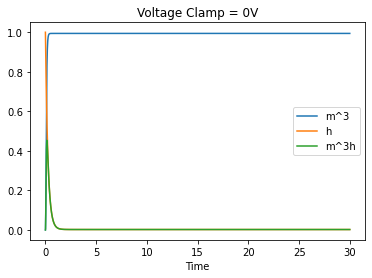

In [9]:
run_HH(0)

/tmp/ipykernel_3318/2954535638.py:2: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


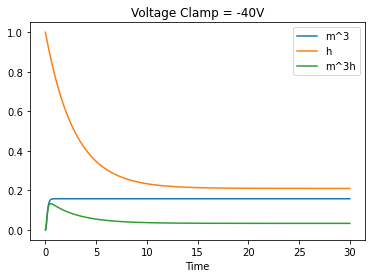

In [10]:
run_HH(-40)